### Msc Data Science & AI  
### IS71130A: Natural Language Processing (2023-24) Assessment 1: Coursework Project
### Chosen Topic: Synthetic Clinical Notes Summarisation
### Author: Sandor Kanda

## **I. Introducion**


<div style="text-align: justify; line-height: 1.5;">

Text Summarisation is a leading topic in information retrieval research, especially valuabe in the clinical field, where the number of patient notes are on a constant rise. This solution offers an efficient solution for accessing scientific and clinical literature, while optimising the note size. This enables users to quickly grasp the critical points of required clinical knowledge, saving search time.

</div>

## **II. Ethics**

<div style="text-align: justify; line-height: 1.5;">

The acquired data does not consist of any identifiable patient data, ensuring compliance with privacy regulations and ethical standards for handling sensitive health information. This approach underscores our commitment to maintaining the confidentiality and integrity of patient information while leveraging synthetic clinical note summarisation for advancing NLP tasks within healthcare, thereby promoting innovations that respect and protect individual privacy.

</div>

License: cc-by-nc-sa-4.0

**Citation Information:**


 
@misc{kweon2023publicly,
    title={Publicly Shareable Clinical Large Language Model Built on Synthetic Clinical Notes},
    author={Sunjun Kweon and Junu Kim and Jiyoun Kim and Sujeong Im and Eunbyeol Cho and Seongsu Bae and Jungwoo Oh and Gyubok Lee and Jong Hak Moon and Seng Chan You and Seungjin Baek and Chang Hoon Han and Yoon Bin Jung and Yohan Jo and Edward Choi},
    year={2023},
    eprint={2309.00237},
    archivePrefix={arXiv},
    primaryClass={cs.CL}
}

## **III. Methods**

### **3.1 Data Acquisition**

The data was downloaded from https://huggingface.co/datasets/starmpcc/Asclepius-Synthetic-Clinical-Notes

To reproduce the code, mount the data to the same directory as the notebook file.

In [1]:
%pip install importlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Uncomment this at first run
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz

In [3]:
""" 
import importlib.util

# Check if NLTK is already installed
if importlib.util.find_spec("nltk") is None:
    !pip install nltk
else:
    print("NLTK is already installed.")

# Check if spacy is already installed
if importlib.util.find_spec("spacy") is None:
    !pip install spacy
else:
    print("spacy is already installed.")
"""

' \nimport importlib.util\n\n# Check if NLTK is already installed\nif importlib.util.find_spec("nltk") is None:\n    !pip install nltk\nelse:\n    print("NLTK is already installed.")\n\n# Check if spacy is already installed\nif importlib.util.find_spec("spacy") is None:\n    !pip install spacy\nelse:\n    print("spacy is already installed.")\n'

In [4]:
!python -m spacy download en_core_web_sm

2024-03-26 10:25:05.688912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 10:25:06.844258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 10:25:06.844402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 10:25:06.845053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

In [25]:
# Dependicies and Requirements
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from tqdm import tqdm
from skfuzzy import cmeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package punkt to /home/skanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/skanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/skanda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/skanda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
data = pd.read_csv('synthetic.csv')

### **3.2 EDA**

In [7]:
data.head()

patient_id                                               note  \
0           0  Discharge Summary:\n\nPatient: 60-year-old mal...   
1           1  Discharge Summary:\n\nAdmission Date: [Insert ...   
2           2  Hospital Course Summary:\n\nAdmission Date: [I...   
3           3  Discharge Summary:\n\nPatient: 69-year-old mal...   
4           4  Discharge Summary:\n\nPatient Information:\n- ...   

                                            question  \
0  Can you provide a simplified paraphrase of the...   
1  Which coreferences were resolved in the hospit...   
2  What were the key improvements in the patient'...   
3  What roles did physical therapists have in the...   
4  What manual airway clearance techniques were u...   

                                              answer                    task  
0  The healthcare team used a gradual approach to...            Paraphrasing  
1  The hospital course section resolved the coref...  Coreference Resolution  
2  During the hospital course, the patient's medi...           Summarization  
3  Physical therapists were responsible for ensur...     Relation Extraction  
4  The discharge summary stated that 1-2 physical...     Relation Extraction

In [8]:
filtered_data = data[data['task'] == 'Summarization']

In [9]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19756 entries, 2 to 158107
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  19756 non-null  int64 
 1   note        19756 non-null  object
 2   question    19756 non-null  object
 3   answer      19756 non-null  object
 4   task        19756 non-null  object
dtypes: int64(1), object(4)
memory usage: 926.1+ KB


In [10]:
filtered_data.isna().sum()

patient_id    0
note          0
question      0
answer        0
task          0
dtype: int64

In [11]:
filtered_data

patient_id                                               note  \
2                2  Hospital Course Summary:\n\nAdmission Date: [I...   
5                5  Discharge Summary:\n\nPatient: 52-year-old mal...   
10              11  Discharge Summary:\n\nPatient Name: [REDACTED]...   
12              13  DISCHARGE SUMMARY:\n\nPatient Name: X\nMedical...   
18              20  Hospital Course:\n\nThe patient is a 78-year-o...   
...            ...                                                ...   
158074      166992  Hospital Course:\n\nThe patient, a 90-year-old...   
158077      166995  DISCHARGE SUMMARY\n\nPatient Information:\nNam...   
158080      166999  Hospital Course: \n\nJK is a 35-year-old male ...   
158088      167008  DISCHARGE SUMMARY\n\nPatient Name: [redacted]\...   
158107      167027  Discharge Summary:\n\nPatient Name: N/A\nAge: ...   

                                                 question  \
2       What were the key improvements in the patient'...   
5       How did the patient's treatment for dysphagia ...   
10      Can you provide a summary of the treatment, ho...   
12      Based on the given discharge summary, can you ...   
18      What are the key findings and diagnosis of the...   
...                                                   ...   
158074  What was the diagnosis and treatment course fo...   
158077  Can you provide a concise summary of the disch...   
158080  What was the response to clofarabine and the p...   
158088  What was the diagnosis, treatment, and recurre...   
158107  What was the chief complaint, past medical his...   

                                                   answer           task  
2       During the hospital course, the patient's medi...  Summarization  
5       During the patient's hospital stay, treatment ...  Summarization  
10      The 45-year-old female patient with a history ...  Summarization  
12      The patient with a multifocal invasive mammary...  Summarization  
18      The key findings of the patient include abnorm...  Summarization  
...                                                   ...            ...  
158074  The 90-year-old male patient was diagnosed wit...  Summarization  
158077  The patient's chief complaint was extreme fati...  Summarization  
158080  The 35-year-old male patient with recurrent T-...  Summarization  
158088  Based on the given discharge summary, the pati...  Summarization  
158107  The female patient's chief complaint was sudde...  Summarization  

[19756 rows x 5 columns]

In [12]:
filtered_data= filtered_data.head(1000)
print(filtered_data)

      patient_id                                               note  \
2              2  Hospital Course Summary:\n\nAdmission Date: [I...   
5              5  Discharge Summary:\n\nPatient: 52-year-old mal...   
10            11  Discharge Summary:\n\nPatient Name: [REDACTED]...   
12            13  DISCHARGE SUMMARY:\n\nPatient Name: X\nMedical...   
18            20  Hospital Course:\n\nThe patient is a 78-year-o...   
...          ...                                                ...   
8169        8624  Discharge Summary:\n\nHospital Course:\n\nThe ...   
8171        8626  Discharge Summary:\n\nAdmission Date: [(date)]...   
8177        8635  DISCHARGE SUMMARY\n\nPatient Name: [REDACTED]\...   
8179        8637  Discharge Summary:\n\nPatient Name: [Redacted]...   
8201        8659  DISCHARGE SUMMARY\n\nPatient Name: N/A\nMedica...   

                                               question  \
2     What were the key improvements in the patient'...   
5     How did the patient's t

In [13]:
print(type(filtered_data))

<class 'pandas.core.frame.DataFrame'>


In [14]:
print(filtered_data.columns)

Index(['patient_id', 'note', 'question', 'answer', 'task'], dtype='object')


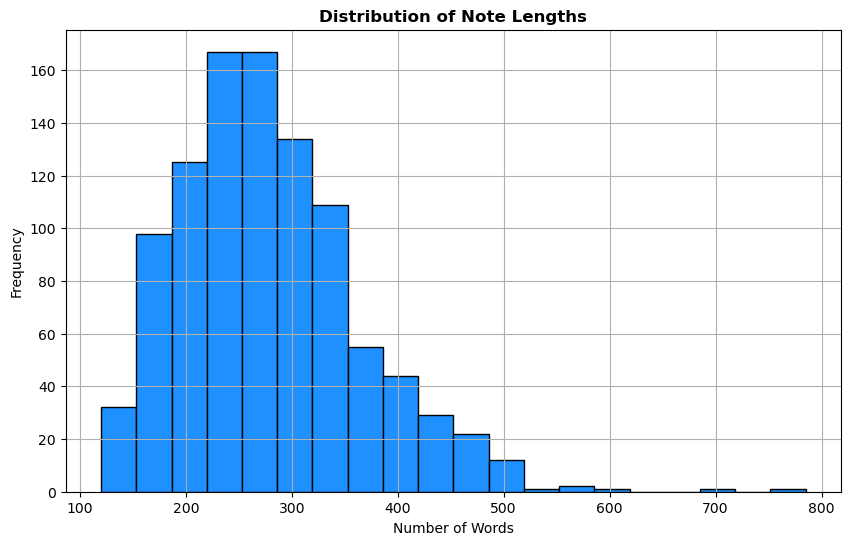

In [15]:
# Distribution of note lengths
plt.figure(figsize=(10, 6))
plt.hist([len(note.split()) for note in filtered_data['note']], bins=20, color='dodgerblue', edgecolor='black')
plt.title('Distribution of Note Lengths', fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

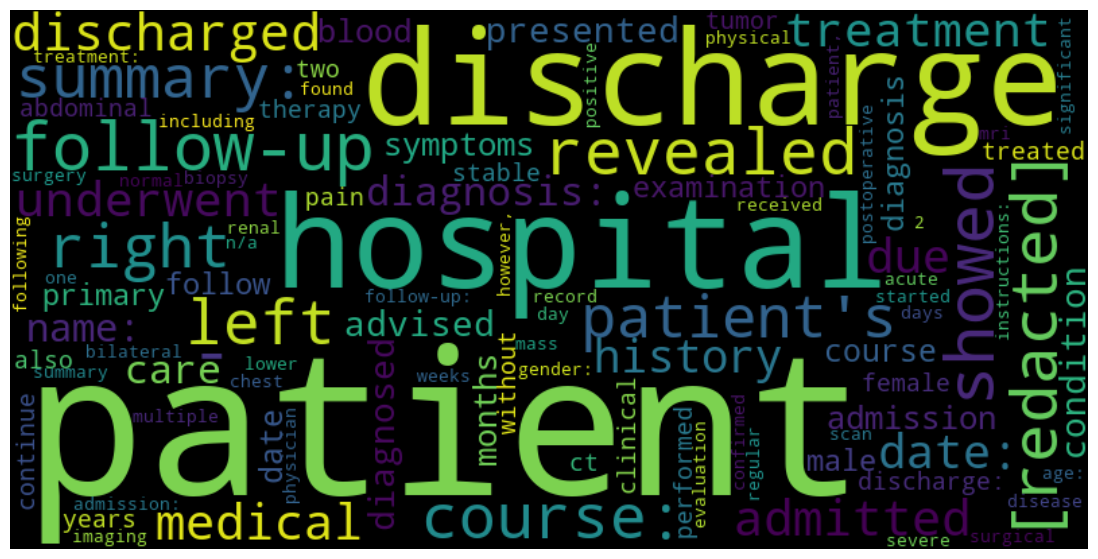

In [30]:
stop_words = set(stopwords.words('english'))
all_notes = " ".join(note.lower() for note in filtered_data['cleaned_note'])

# Tokenize the string into words
words = all_notes.split()

# Remove stopwords
words = [word for word in words if word not in stop_words]


word_freq = Counter(words)
common_words = dict(word_freq.most_common(100))
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate_from_frequencies(common_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

### **3.3 Text Cleaning and Preprocessing**

In [16]:
class TextPreprocessor:
    def __init__(self):
        self.placeholder_pattern = r'\[Insert date\]|\[Insert Number\]|\[Patient\'s Name\]|Patient\'s Name:'
        self.stop_words = set(stopwords.words('english'))
  
    def clean_text(self, text_series):
        """
        Cleans the input text by performing several preprocessing steps: placeholder removal, case normalization,
        and whitespace normalization.

        :param text_series: A pandas Series containing the raw text.
        :return: A pandas Series containing the cleaned text.
        """
        cleaned_text = text_series.str.replace(self.placeholder_pattern, '', regex=True, case=False)
        cleaned_text = cleaned_text.str.lower()
        cleaned_text = cleaned_text.str.split().str.join(' ')
        return cleaned_text

    def preprocess_text(self, text):
        """
        Preprocesses the given text by performing several steps: sentence segmentation, word tokenization,
        stemming, lemmatization, stop word removal, and part-of-speech tagging.

        :param text: The input cleaned text to preprocess.
        :return: A dictionary containing various levels of processed text.
        """
        # Initial preprocessing steps
        sentences = sent_tokenize(text) 
        words = [word_tokenize(sentence) for sentence in sentences]
        filtered_sentences = [[word for word in word_list if word not in self.stop_words] for word_list in words]

        # Part-of-Speech Tagging
        flat_words = [word for sublist in filtered_sentences for word in sublist]
        pos_tags = nltk.pos_tag(flat_words)

        return {
            'sentences': sentences,
            'words': words,
            'filtered_sentences': filtered_sentences,
            'pos_tags': pos_tags
        }

text_preprocessor = TextPreprocessor()
filtered_data['cleaned_note'] = text_preprocessor.clean_text(filtered_data['note'])


# Convert 'cleaned_note' column to string type
filtered_data['cleaned_note'] = filtered_data['cleaned_note'].astype(str)

filtered_data['preprocessed_text'] = filtered_data['cleaned_note'].apply(text_preprocessor.preprocess_text)


sentences = filtered_data['preprocessed_text'].iloc[0]['sentences']
print("Sentences:", sentences)

filtered_sentences = filtered_data['preprocessed_text'].iloc[0]['filtered_sentences']
print("Filtered Sentences:", filtered_sentences)

pos_tags = filtered_data['preprocessed_text'].iloc[0]['pos_tags']
print("POS Tags:", pos_tags)

/tmp/ipykernel_3183786/3990181664.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cleaned_note'] = text_preprocessor.clean_text(filtered_data['note'])
/tmp/ipykernel_3183786/3990181664.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cleaned_note'] = filtered_data['cleaned_note'].astype(str)


Sentences: ['hospital course summary: admission date: discharge date: patient: sex: male age: 57 years admission diagnosis: oxygen desaturation hospital course: the patient was admitted to the icu one week after a positive covid-19 result due to oxygen desaturation.', "physical therapy was initiated promptly after admission, which helped improve the patient's breathing frequency and oxygen saturation.", 'the patient was guided to achieve a prone position resulting in a significant increase in oxygen saturation from 88% to 96%.', 'the patient continued to receive intensive physical therapy, positioning, and oxygen therapy for the next few days.', "although there were challenges in achieving the prone position due to the patient's profoundly reduced respiratory capacity and high risk of symptom exacerbation, the medical team succeeded in implementing a safe and individualized approach.", 'after three days with this regime, the patient was transferred to the normal ward, where physical th

/tmp/ipykernel_3183786/3990181664.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['preprocessed_text'] = filtered_data['cleaned_note'].apply(text_preprocessor.preprocess_text)


### **3.4 Feature Extraction**

In [17]:
nlp = spacy.load("en_core_sci_sm")

def extract_entities(filtered_data):
    """
    Extracts medical entities from the input text.

    :param text: The input text to extract features from.
    :return: A list containing the medical entities.
    """
    doc = nlp(filtered_data)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

tfidf_vectorizer = TfidfVectorizer()

# Fit the TF-IDF vectorizer to learn the vocabulary from all notes
all_notes = filtered_data['cleaned_note'].tolist()
tfidf_vectorizer.fit(all_notes)

# Initialize lists to store results for each note
all_entities = []
all_tfidf_vectors = []

for note in all_notes:
    entities = extract_entities(note)
    all_entities.append(entities)

    # Transform the note into its TF-IDF vector representation
    tfidf_vector = tfidf_vectorizer.transform([note])
    all_tfidf_vectors.append(tfidf_vector)

print("Medical Entities for the first note:")
print(all_entities[0])

print("\nTF-IDF Vector for the first note (in sparse matrix format):")
print(all_tfidf_vectors[0])

Medical Entities for the first note:
[('hospital course', 'ENTITY'), ('admission', 'ENTITY'), ('discharge', 'ENTITY'), ('patient', 'ENTITY'), ('sex', 'ENTITY'), ('male', 'ENTITY'), ('age', 'ENTITY'), ('years', 'ENTITY'), ('admission', 'ENTITY'), ('diagnosis', 'ENTITY'), ('oxygen desaturation hospital course', 'ENTITY'), ('patient', 'ENTITY'), ('admitted', 'ENTITY'), ('week', 'ENTITY'), ('positive', 'ENTITY'), ('covid-19', 'ENTITY'), ('oxygen desaturation', 'ENTITY'), ('physical therapy', 'ENTITY'), ('admission', 'ENTITY'), ("patient's", 'ENTITY'), ('breathing frequency', 'ENTITY'), ('oxygen saturation', 'ENTITY'), ('patient', 'ENTITY'), ('prone position', 'ENTITY'), ('increase', 'ENTITY'), ('oxygen saturation', 'ENTITY'), ('patient', 'ENTITY'), ('physical therapy', 'ENTITY'), ('positioning', 'ENTITY'), ('oxygen therapy', 'ENTITY'), ('days', 'ENTITY'), ('prone position', 'ENTITY'), ("patient's", 'ENTITY'), ('profoundly', 'ENTITY'), ('reduced', 'ENTITY'), ('respiratory capacity', 'ENTITY

### **3.5 Hierarchical Clustering**

In [18]:
def combine_features(entities, tfidf_vector):
    """
    Attempt to combine one-hot encoded entity labels with the TF-IDF vector.
    This example sidesteps dimensionality issues by simplifying the approach.
    :param entities: A list of entities extracted from the text.
    :param tfidf_vector: The TF-IDF vector for the text.
    :return: A combined feature vector.
    """
    # Directly return the TF-IDF vector if no entities are extracted
    if not entities:
        return tfidf_vector.toarray()

    num_entities = len(set([label for _, label in entities]))
    tfidf_dense = tfidf_vector.toarray()

    combined_features = np.append(tfidf_dense, [[num_entities]], axis=1)
    return combined_features

def apply_fuzzy_clustering(combined_features, n_clusters=3, m=2, error=0.005, maxiter=1000):
    """
    Applies fuzzy c-means clustering on the combined features.
    :param combined_features: The combined feature vector.
    :param n_clusters: The number of clusters to create (default: 3).
    :param m: The fuzziness parameter (default: 2).
    :param error: The stopping criterion for the fuzzy c-means algorithm (default: 0.005).
    :param maxiter: The maximum number of iterations for the fuzzy c-means algorithm (default: 1000).
    :return: A tuple containing the cluster centers, cluster membership values, and the number of iterations.
    """

    cntr, u, _, _, _, _, _ = cmeans(
        combined_features.T, n_clusters, m, error=error, maxiter=maxiter, init=None
    )

    # Calculate the membership values for each sample
    membership_values = np.argmax(u, axis=0)
    return cntr, u, membership_values

# Process the clinical notes
combined_features_list = []
for note in tqdm(filtered_data['cleaned_note'], desc="Extracting features"):
    entities = extract_entities(note)
    tfidf_vector = tfidf_vectorizer.transform([note])
    combined_features = combine_features(entities, tfidf_vector)
    combined_features_list.append(combined_features)


combined_features_array = np.vstack(combined_features_list)

n_clusters = 3
cluster_centers, membership_values, membership_labels = apply_fuzzy_clustering(combined_features_array, n_clusters=n_clusters)

print(f"Cluster Centers:\n{cluster_centers}")
print(f"\nMembership Values:\n{membership_values}")
print(f"\nMembership Labels:\n{membership_labels}")

Extracting features: 100%|██████████| 1000/1000 [00:28<00:00, 34.59it/s]


Cluster Centers:
[[3.60954083e-04 5.93055302e-04 7.49754813e-05 ... 3.10240005e-04
  4.28586194e-04 1.00000000e+00]
 [3.60981009e-04 5.93022742e-04 7.49845023e-05 ... 3.10274900e-04
  4.28538461e-04 1.00000000e+00]
 [3.60960834e-04 5.93066613e-04 7.49848362e-05 ... 3.10210061e-04
  4.28680855e-04 1.00000000e+00]]

Membership Values:
[[0.333333   0.3333334  0.33333504 ... 0.33333334 0.33333262 0.33333317]
 [0.33333298 0.33333264 0.33333142 ... 0.33333372 0.33333385 0.33333311]
 [0.33333402 0.33333396 0.33333354 ... 0.33333294 0.33333352 0.33333371]]

Membership Labels:
[2 2 0 0 2 2 0 2 2 2 1 2 0 2 2 2 0 2 1 1 1 0 2 2 2 0 2 2 0 1 0 1 0 0 1 0 2
 2 1 1 1 1 0 1 0 2 0 1 1 0 2 2 0 1 0 0 2 0 1 2 0 1 1 2 2 2 1 0 0 1 1 1 1 0
 2 1 2 2 1 2 1 1 0 1 1 2 1 2 2 0 1 2 2 0 2 0 0 1 1 1 2 1 0 1 0 0 0 1 2 0 2
 0 1 2 2 2 2 0 2 0 1 1 1 0 1 2 1 0 2 2 2 1 2 2 2 1 1 1 0 0 0 1 0 2 1 0 0 2
 2 2 2 2 1 2 2 0 1 1 0 2 2 2 2 2 1 1 1 1 2 1 1 2 1 1 0 1 1 1 2 1 2 0 2 0 2
 1 2 2 2 1 2 1 0 1 0 0 0 1 2 1 1 0 0 1 1 2 0 0 1 1

For n_clusters = 2, the mean silhouette score is: 0.005435353018230481
For n_clusters = 3, the mean silhouette score is: -0.002666229508830579
For n_clusters = 4, the mean silhouette score is: 0.0013076270500613143
For n_clusters = 5, the mean silhouette score is: -0.004294254993990615
For n_clusters = 6, the mean silhouette score is: -0.0050184278294863995
For n_clusters = 7, the mean silhouette score is: -0.005071103372437267
For n_clusters = 8, the mean silhouette score is: -0.007308107092126662
For n_clusters = 9, the mean silhouette score is: -0.00668115158885936
The optimal number of clusters is: 2 with a silhouette score of 0.005435353018230481


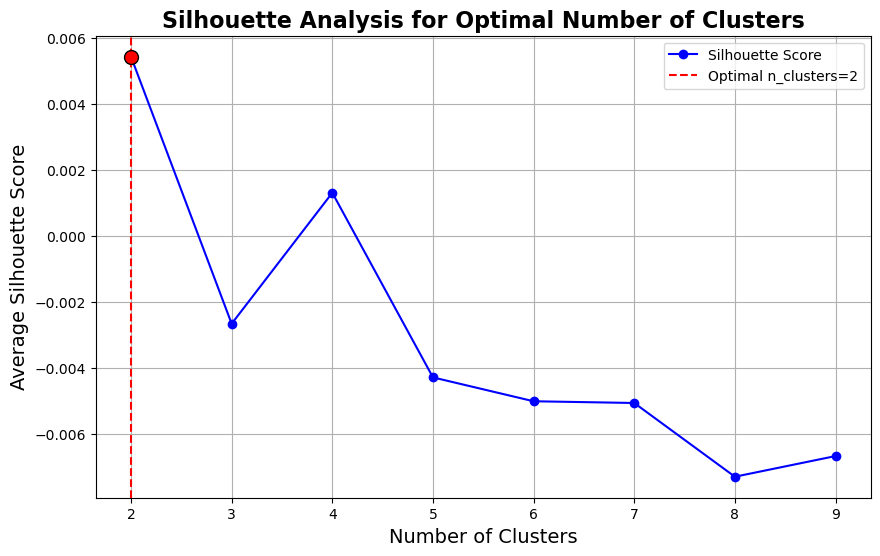

In [19]:
n_clusters_range = range(2, 10)
silhouette_scores = []

for n_clusters in n_clusters_range:
    # Apply fuzzy clustering
    cluster_centers, membership_values, membership_labels = apply_fuzzy_clustering(combined_features_array, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(combined_features_array, membership_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the mean silhouette score is: {silhouette_avg}")

optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
optimal_silhouette_score = max(silhouette_scores)
print(f"The optimal number of clusters is: {optimal_n_clusters} with a silhouette score of {optimal_silhouette_score}")


plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Average Silhouette Score', fontsize=14)
plt.title('Silhouette Analysis for Optimal Number of Clusters', fontweight='bold', fontsize=16)


plt.axvline(x=optimal_n_clusters, color='red', linestyle='--', label=f'Optimal n_clusters={optimal_n_clusters}')
plt.scatter(optimal_n_clusters, optimal_silhouette_score, color='red', s=100, edgecolor='black', zorder=5)

plt.grid(True)
plt.legend()
plt.show()



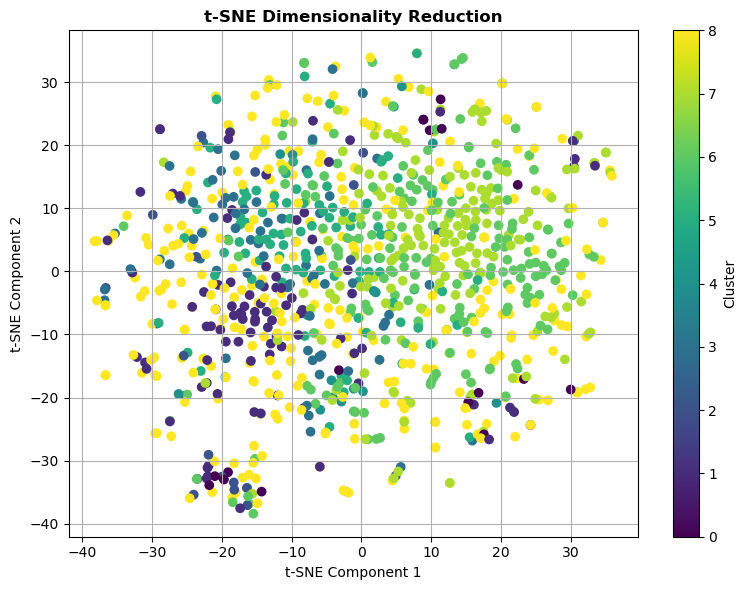

In [20]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)  
pca_features = pca.fit_transform(combined_features_array)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  
tsne_features = tsne.fit_transform(combined_features_array)


plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=membership_labels, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Dimensionality Reduction', fontweight='bold')
plt.grid(True)
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

### **3.6 Model Building- TextRank**

**Option 1 Summarisation = Top 5 sentences**

In [21]:
def summarize_note(note_text, top_n_sentences=5):
    """
    Generate a summary for a given note text.
    :param note_text: A string containing the full note text.
    :param top_n_sentences: Number of sentences to include in the summary.
    :return: A summary string.
    """
    # Tokenize the note into sentences
    sentences = nltk.sent_tokenize(note_text)

    # Preprocess sentences to remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_sentences = [[word for word in nltk.word_tokenize(sentence.lower()) if word not in stop_words] for sentence in sentences]
    filtered_sentences_texts = [' '.join(sentence) for sentence in filtered_sentences]

    # Vectorize sentences
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_sentences_texts)

    # Compute similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Build the graph
    graph = nx.from_numpy_array(cosine_sim_matrix)
    scores = nx.pagerank(graph)

    # Sort sentences by score
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    summary_indices = ranked_indices[:top_n_sentences]
    summary_sentences = [sentences[i] for i in summary_indices]
    summary_sentences = [sentence.capitalize() for sentence in summary_sentences]


    summary = ' '.join(summary_sentences)
    return summary


filtered_data['summary'] = filtered_data['cleaned_note'].apply(summarize_note)
print(filtered_data[['cleaned_note', 'summary']])


                                           cleaned_note  \
2     hospital course summary: admission date: disch...   
5     discharge summary: patient: 52-year-old male h...   
10    discharge summary: patient name: [redacted] me...   
12    discharge summary: patient name: x medical rec...   
18    hospital course: the patient is a 78-year-old ...   
...                                                 ...   
8169  discharge summary: hospital course: the patien...   
8171  discharge summary: admission date: [(date)] di...   
8177  discharge summary patient name: [redacted] med...   
8179  discharge summary: patient name: [redacted] ag...   
8201  discharge summary patient name: n/a medical re...   

                                                summary  
2     Physical therapy was initiated promptly after ...  
5     Discharge summary: patient: 52-year-old male h...  
10    Post-discharge plan: the patient will continue...  
12    The patient received adjuvant pmrt and underwe...  
1

/tmp/ipykernel_3183786/2563185556.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['summary'] = filtered_data['cleaned_note'].apply(summarize_note)


**Option 2- Summmarisation ratio = 25%**

In [22]:
def summarize_note(note_text, summary_ratio=0.25):
    """
    Generate a summary for a given note text.
    :param note_text: A string containing the full note text.
    :param summary_ratio: The desired ratio of the summary word count to the original note word count.
    :return: A summary string.
    """
   
    sentences = nltk.sent_tokenize(note_text)

    # Preprocess sentences to remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_sentences = [[word for word in nltk.word_tokenize(sentence.lower()) if word not in stop_words]
                          for sentence in sentences]
    filtered_sentences_texts = [' '.join(sentence) for sentence in filtered_sentences]


    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_sentences_texts)

    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    graph = nx.from_numpy_array(cosine_sim_matrix)
    scores = nx.pagerank(graph)

    # Calculate the desired number of sentences based on the summary ratio
    note_word_count = len(note_text.split())
    desired_summary_word_count = int(note_word_count * summary_ratio)
    average_sentence_word_count = note_word_count // len(sentences)
    desired_num_sentences = max(1, desired_summary_word_count // average_sentence_word_count)

    # Sort sentences by score
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    summary_indices = ranked_indices[:desired_num_sentences]
    summary_sentences = [sentences[i] for i in summary_indices]
    summary_sentences = [sentence.capitalize() for sentence in summary_sentences]


    summary = ' '.join(summary_sentences)
    return summary


filtered_data['summary'] = filtered_data['cleaned_note'].apply(lambda x: summarize_note(x, summary_ratio=0.25))
print(filtered_data['summary'])

2       Physical therapy was initiated promptly after ...
5       Discharge summary: patient: 52-year-old male h...
10      Post-discharge plan: the patient will continue...
12      The patient received adjuvant pmrt and underwe...
18      The patient and family opted for comfort care ...
                              ...                        
8169    Discharge summary: hospital course: the patien...
8171    Discharge summary: admission date: [(date)] di...
8177    Discharge diagnosis: recurrence of epithelial ...
8179    The patient's primary care physician was infor...
8201    Repeat follow-up tte showed gradual normalizat...
Name: summary, Length: 1000, dtype: object


/tmp/ipykernel_3183786/1792613649.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['summary'] = filtered_data['cleaned_note'].apply(lambda x: summarize_note(x, summary_ratio=0.25))


In [31]:
first_note = filtered_data['note'].iloc[0]
first_summary = filtered_data['summary'].iloc[0]

print("Original Note:\n", first_note)
print("\nSummarized Note:\n", first_summary)

Original Note:
 Hospital Course Summary:

Admission Date: [Insert date]
Discharge Date: [Insert date]

Patient: [Patient's Name]
Sex: Male
Age: 57 years

Admission Diagnosis: Oxygen Desaturation

Hospital Course:

The patient was admitted to the ICU one week after a positive COVID-19 result due to oxygen desaturation. Physical therapy was initiated promptly after admission, which helped improve the patient's breathing frequency and oxygen saturation. The patient was guided to achieve a prone position resulting in a significant increase in oxygen saturation from 88% to 96%. The patient continued to receive intensive physical therapy, positioning, and oxygen therapy for the next few days. Although there were challenges in achieving the prone position due to the patient's profoundly reduced respiratory capacity and high risk of symptom exacerbation, the medical team succeeded in implementing a safe and individualized approach.

After three days with this regime, the patient was transferre

#### **3.7 ROUGE score for NLP Evaluation**

In [23]:
rouge = Rouge()

precision_sum = 0
recall_sum = 0
f1_sum = 0
num_notes = 0

for i, row in filtered_data.iterrows():
    original_text = row['note']  # The original note
    generated_summary = row['summary']  # The provided summary for the note

    # Calculate ROUGE scores
    scores = rouge.get_scores(generated_summary, original_text)[0]['rouge-l']

    print(f"ROUGE-L scores for note {i}:")
    print("Precision:", scores['p'])
    print("Recall:", scores['r'])
    print("F1 Score:", scores['f'])
    print()

    precision_sum += scores['p']
    recall_sum += scores['r']
    f1_sum += scores['f']
    num_notes += 1

precision_mean = precision_sum / num_notes
recall_mean = recall_sum / num_notes
f1_mean = f1_sum / num_notes

print("Mean ROUGE-L scores:")
print("Precision:", precision_mean)
print("Recall:", recall_mean)
print("F1 Score:", f1_mean)


ROUGE-L scores for note 2:
Precision: 0.98
Recall: 0.31210191082802546
F1 Score: 0.47342994802679184

ROUGE-L scores for note 5:
Precision: 0.9107142857142857
Recall: 0.3422818791946309
F1 Score: 0.4975609716387865

ROUGE-L scores for note 10:
Precision: 0.7777777777777778
Recall: 0.27450980392156865
F1 Score: 0.40579709759294275

ROUGE-L scores for note 12:
Precision: 0.9827586206896551
Recall: 0.3114754098360656
F1 Score: 0.4730290419882578

ROUGE-L scores for note 18:
Precision: 0.9444444444444444
Recall: 0.26356589147286824
F1 Score: 0.4121212087096419

ROUGE-L scores for note 33:
Precision: 0.9111111111111111
Recall: 0.33884297520661155
F1 Score: 0.49397589966250555

ROUGE-L scores for note 41:
Precision: 0.8767123287671232
Recall: 0.2644628099173554
F1 Score: 0.40634920278841025

ROUGE-L scores for note 44:
Precision: 0.7547169811320755
Recall: 0.20408163265306123
F1 Score: 0.32128513721133534

ROUGE-L scores for note 45:
Precision: 0.9767441860465116
Recall: 0.2937062937062937
F

In [24]:
rouge = Rouge()
scores_list = []

for i, row in filtered_data.iterrows():
    original_text = row['note']  # The original note
    generated_summary = row['summary']  # The provided summary for the note

    scores = rouge.get_scores(generated_summary, original_text)[0]['rouge-l']

    # Append individual scores to the list
    scores_list.append({
        'Note Index': i,
        'Precision': scores['p'],
        'Recall': scores['r'],
        'F1 Score': scores['f']
    })


scores_df = pd.DataFrame(scores_list)

# Melt the DataFrame 
melted_scores_df = scores_df.melt(id_vars='Note Index', value_vars=['Precision', 'Recall', 'F1 Score'], 
                                  var_name='Metric', value_name='Score')


fig = px.line(melted_scores_df, x='Note Index', y='Score', color='Metric', markers=True,
              labels={'Score': 'Score'},
              title='ROUGE-L Performance Metrics Across Notes')

fig.update_layout(
    title={
        'text': 'ROUGE-L Performance Metrics Across Notes',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Arial Black, sans-serif", 
            size=18, 
            color="RebeccaPurple"
        ),
    },
    xaxis_title='Note Index',
    yaxis_title='Score',
    legend_title='Metric',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()
